# Vacancy analysis

We want to estimate the rate of vacancy hopping, to use this as a way to
1. sanity check what is happening in the proxima "no diffusion case"
2. double-check our MSD-based diffusivity calculations
3. check that the vacancy hops follow the expected distribution, sanity checking our science in general

In [1]:
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm
import ase
from ase.io import read

## Reading the data

we'll start with a full dft trajectory

In [2]:
path = Path('runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-01bd9480/')

In [3]:
with open(path/'params.json') as f: 
    params = json.load(f)
params['min_target_frac'] == 1 # shows us this is a DFT-only run

True

In [4]:
traj = read(path/'md.traj', index=':')

In [5]:
len(traj)

40001

In [6]:
atoms = traj[0]

## Testing the vacancy estimation

First we get all of the minimum image distances

In [7]:
D = atoms.get_all_distances(mic=True)

Text(0, 0.5, 'count')

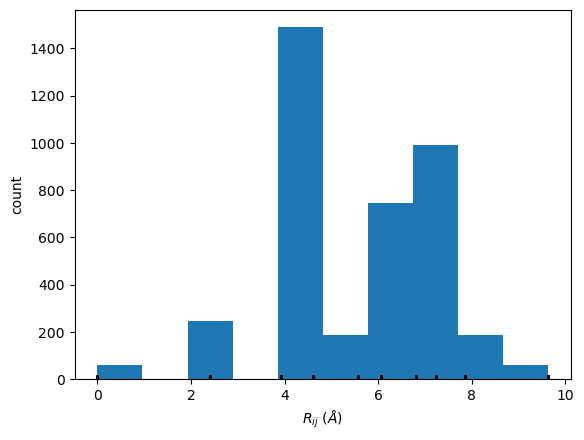

In [8]:
plt.hist(D.ravel());
plt.plot(D.ravel(), [0.1]* len(D.ravel()), '|', color='k');
plt.xlabel('$R_{ij}$ ($\AA$)')
plt.ylabel('count')

The first bin is the self distances (zero), the second bin is likely the covalently bonded Si atoms, lets see what happens if we take a cutoff just above that

In [9]:
r_cut = 3

And then find the number of neighbors

In [10]:
nn = (D < r_cut).sum(1) - 1 # subtract 1 for self distances
pd.Series(nn).value_counts()

4    59
3     4
Name: count, dtype: int64

So 59 of the atoms have 4 neighbors and 4 of them (those near the vacancy) have 3 neighbors. This seems reasonable. 

## Finding vacancy hopping

First lets bundle the code from above

In [11]:
def get_n_neighbors(atoms: ase.Atoms, r_cut: float = 3) -> np.ndarray[int]:
    D = atoms.get_all_distances(mic=True)
    nn = (D < r_cut).sum(1) - 1 # subtract 1 for self distances
    return nn

In [12]:
get_n_neighbors(atoms)

array([3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4])

And loop it over the trajectory, detecting: 

1. when the # neighbors is 'wrong' during a vacancy hop or similar
2. when the distirbution of # neighbors over atoms changes

In [13]:
correct_counts = pd.Series(nn).value_counts()
correct_counts

4    59
3     4
Name: count, dtype: int64

In [14]:
%%time
atoms = traj[0]
nn = get_n_neighbors(atoms)


# track whether a timestep has a 'wrong' or new configuration of neighbors
steps_wrong = np.zeros(len(traj))
steps_new = np.zeros(len(traj))
nn_all = [nn]

for t, atoms in enumerate(traj[1:]):
    print(f'{t}/{len(traj)}', end='\r')
    nn_new = get_n_neighbors(atoms)
    counts = pd.Series(nn_new).value_counts()

    # check whether we have the correct neighbor count distribution
    # handling the case where series comparison is invalid
    try: 
        is_correct = (counts == correct_counts).all()
    except: 
        is_correct = False
    

    # if we do have the correct neighbor count distribution
    # check if the atoms with these counts have changed
    if is_correct: 
        is_new = not (nn == nn_new).all()
        if is_new: 
            # count this as a new state
            steps_new[t] = 1
            # update the reference n_neighbor distribution
            nn = nn_new
    else: 
        steps_wrong[t] = 1

CPU times: user 25min 54s, sys: 48min 56s, total: 1h 14min 51s
Wall time: 3min 53s


In [15]:
steps_new.sum()

120.0

In [16]:
steps_wrong.sum()

15270.0

In [17]:
start = 5000
stop  = 8_000

In [18]:
t = np.arange(len(traj))

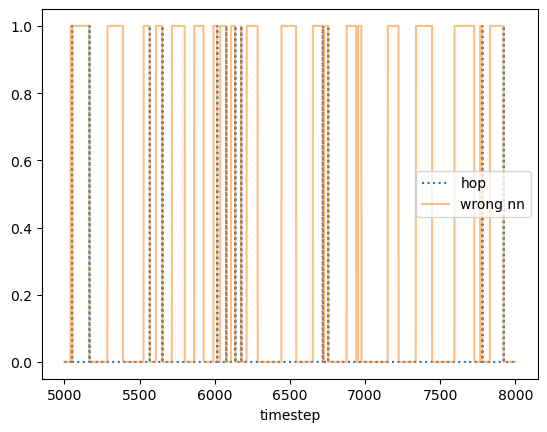

In [19]:
plt.plot(
    t[start:stop],
    steps_new[start:stop], 
    linestyle='dotted', 
    label='hop')
plt.plot(t[start:stop], 
         steps_wrong[start:stop], 
         alpha=0.5, label='wrong nn')
plt.xlabel('timestep')
plt.legend()

## Find the length of time between the hops

In [20]:
hop_indices = np.where(steps_new == 1)[0]
hop_indices

array([  133,   308,  2398,  2476,  3776,  3829,  4585,  4760,  5051,
        5167,  5568,  5652,  6017,  6077,  6137,  6177,  6719,  6755,
        7780,  7922,  8089,  8141,  8257,  8386,  8517,  8533,  9346,
        9393, 10187, 10243, 11818, 11868, 12557, 12601, 13786, 13809,
       13946, 13956, 14025, 14091, 14311, 14361, 14440, 14499, 15622,
       15658, 16941, 17051, 17246, 17288, 18476, 18529, 19985, 20036,
       20749, 21622, 21651, 21817, 21901, 23275, 23316, 23397, 23445,
       23524, 23746, 23767, 25177, 25189, 25262, 25332, 25483, 25546,
       25903, 25995, 26204, 26237, 27314, 27406, 28246, 28291, 28419,
       28542, 29302, 29373, 29412, 29606, 29643, 30443, 30532, 32205,
       32267, 32319, 32416, 32473, 32594, 32655, 32737, 32845, 33080,
       33089, 33255, 33301, 33487, 33521, 33541, 33717, 33730, 34958,
       35043, 35760, 35852, 36665, 36703, 36808, 36944, 38116, 38121,
       38175, 38655, 38738])

In [21]:
durations = np.diff(hop_indices)
durations

array([ 175, 2090,   78, 1300,   53,  756,  175,  291,  116,  401,   84,
        365,   60,   60,   40,  542,   36, 1025,  142,  167,   52,  116,
        129,  131,   16,  813,   47,  794,   56, 1575,   50,  689,   44,
       1185,   23,  137,   10,   69,   66,  220,   50,   79,   59, 1123,
         36, 1283,  110,  195,   42, 1188,   53, 1456,   51,  713,  873,
         29,  166,   84, 1374,   41,   81,   48,   79,  222,   21, 1410,
         12,   73,   70,  151,   63,  357,   92,  209,   33, 1077,   92,
        840,   45,  128,  123,  760,   71,   39,  194,   37,  800,   89,
       1673,   62,   52,   97,   57,  121,   61,   82,  108,  235,    9,
        166,   46,  186,   34,   20,  176,   13, 1228,   85,  717,   92,
        813,   38,  105,  136, 1172,    5,   54,  480,   83])

In [22]:
hop_indices[0]

133

In [23]:
np.insert(durations, 0, hop_indices[0])

array([ 133,  175, 2090,   78, 1300,   53,  756,  175,  291,  116,  401,
         84,  365,   60,   60,   40,  542,   36, 1025,  142,  167,   52,
        116,  129,  131,   16,  813,   47,  794,   56, 1575,   50,  689,
         44, 1185,   23,  137,   10,   69,   66,  220,   50,   79,   59,
       1123,   36, 1283,  110,  195,   42, 1188,   53, 1456,   51,  713,
        873,   29,  166,   84, 1374,   41,   81,   48,   79,  222,   21,
       1410,   12,   73,   70,  151,   63,  357,   92,  209,   33, 1077,
         92,  840,   45,  128,  123,  760,   71,   39,  194,   37,  800,
         89, 1673,   62,   52,   97,   57,  121,   61,   82,  108,  235,
          9,  166,   46,  186,   34,   20,  176,   13, 1228,   85,  717,
         92,  813,   38,  105,  136, 1172,    5,   54,  480,   83])

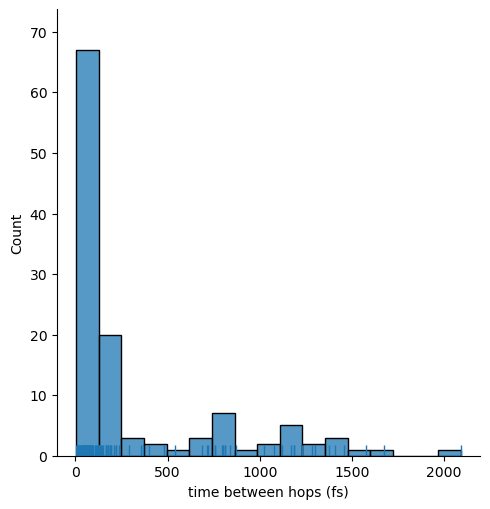

In [24]:
sns.displot(durations, rug=True)
plt.xlabel('time between hops (fs)');

That looks pretty good!

## comparing to no blending proxima:

In [25]:
cat runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-526f7ee4/params.json

{
  "file": null,
  "starting_strc": "../0_setup/initial-geometries/si-vacancy-2x2x2.vasp",
  "temperature": 1573.0,
  "timestep": 1,
  "calculator": "lda",
  "ensemble": "nvt",
  "temp_tau": 25,
  "stress_tau": 25.0,
  "steps": 40000,
  "seed": 9,
  "bulk_modulus": 98.0,
  "initial_volume": 1376.0,
  "model_type": "ani",
  "initial_model": null,
  "initial_data": [],
  "ensemble_size": 2,
  "online_training": true,
  "training_epochs": 16,
  "training_batch_size": 32,
  "training_max_size": 512,
  "training_recency_bias": 1.0,
  "training_device": "cpu",
  "target_error": 0.9,
  "error_history": 8,
  "retrain_freq": 512,
  "min_target_frac": 0.1,
  "n_blending_steps": 0,
  "cascade_commit": "5fda70cf55730fb117bf65924cfd5fae9fd3b0ed",
  "my_commit": "5fda70cf55730fb117bf65924cfd5fae9fd3b0ed",
  "start_time": "2024-10-04T14:28:50.486769"
}

In [26]:
hops = np.load('runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-526f7ee4/hops.npz')

In [27]:
hops['hop_indices'].shape

(212,)

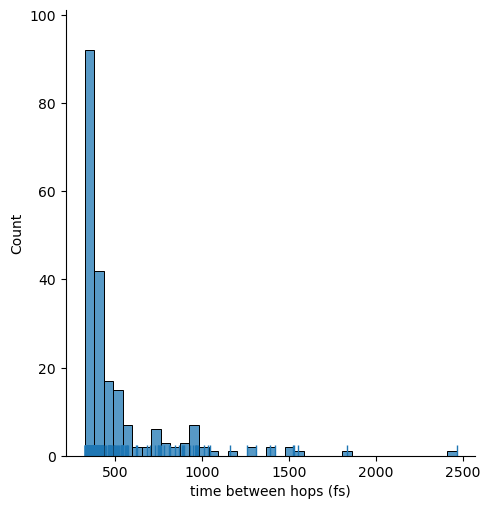

In [28]:
sns.displot(hops['durations'], rug=True)
plt.xlabel('time between hops (fs)');

## Looking at results of the script applied to all of our runs

In [2]:
from glob import glob

In [7]:
run_dirs = glob('runs/nvt-fixed-temp/si-*')

In [9]:
df = []

for d in run_dirs:
    
    d = Path(d)
    with open(d/'params.json') as f: 
        params = json.load(f)

    hops = np.load(d/'hops.npz')
    durations = hops['durations']
    hash_ = str(d)[-8:]

    keep_keys = ['min_target_frac', 'n_blending_steps']
    df.append([params[k] for k in keep_keys] + [durations, hash_])
df = pd.DataFrame.from_records(df, columns=keep_keys+['durations', 'hash'])

In [10]:
df['durations'].map(lambda l:list(sorted(l)))

0     [4, 7, 11, 14, 15, 17, 18, 19, 19, 20, 21, 21,...
1     [6, 8, 12, 17, 18, 19, 19, 22, 23, 23, 26, 29,...
2     [9, 9, 11, 13, 15, 18, 18, 21, 23, 25, 27, 28,...
3     [7, 10, 16, 18, 19, 20, 20, 22, 25, 28, 34, 36...
4     [7, 8, 8, 12, 12, 14, 15, 15, 18, 21, 22, 22, ...
5     [9, 10, 13, 20, 22, 25, 26, 27, 28, 30, 30, 32...
6     [6, 8, 9, 11, 12, 12, 13, 14, 15, 15, 16, 16, ...
7     [2, 4, 8, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, 1...
8     [12, 20, 27, 31, 31, 32, 33, 33, 36, 37, 37, 3...
9     [1, 2, 4, 5, 6, 6, 6, 7, 8, 9, 10, 11, 11, 11,...
10    [5, 8, 12, 13, 15, 17, 18, 21, 22, 23, 25, 27,...
11    [5, 6, 6, 9, 9, 10, 11, 11, 11, 12, 12, 13, 13...
12    [5, 6, 6, 8, 8, 10, 10, 11, 13, 14, 15, 17, 17...
13    [13, 14, 17, 17, 18, 19, 19, 20, 21, 21, 21, 2...
14    [8, 9, 10, 13, 13, 16, 17, 17, 19, 19, 24, 24,...
15    [6, 8, 9, 15, 16, 18, 18, 19, 21, 22, 24, 24, ...
16    [5, 7, 7, 11, 13, 15, 15, 19, 19, 20, 21, 21, ...
17    [5, 5, 7, 7, 8, 8, 10, 10, 11, 12, 12, 13,

In [11]:
df['durations'].map(sum)

0     38814
1     38834
2     37789
3     38222
4     39770
5     36692
6     39319
7     39466
8     39651
9     39553
10    38383
11    38943
12    39817
13    36975
14    39534
15    39419
16    38002
17    38907
18    39623
19    39607
20    39428
21    38605
22    35115
23    39072
24    39214
25    38796
26    39129
27    38984
28    39480
29    37520
Name: durations, dtype: int64

In [12]:
df['durations'][22].sum()

35115

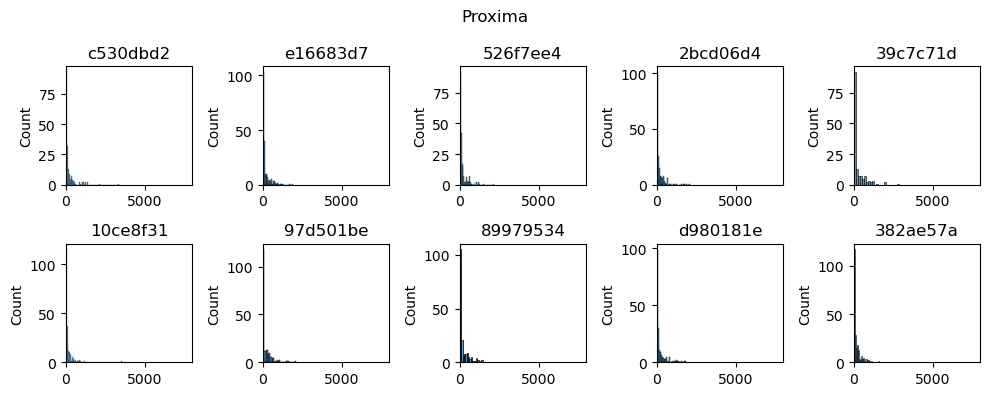

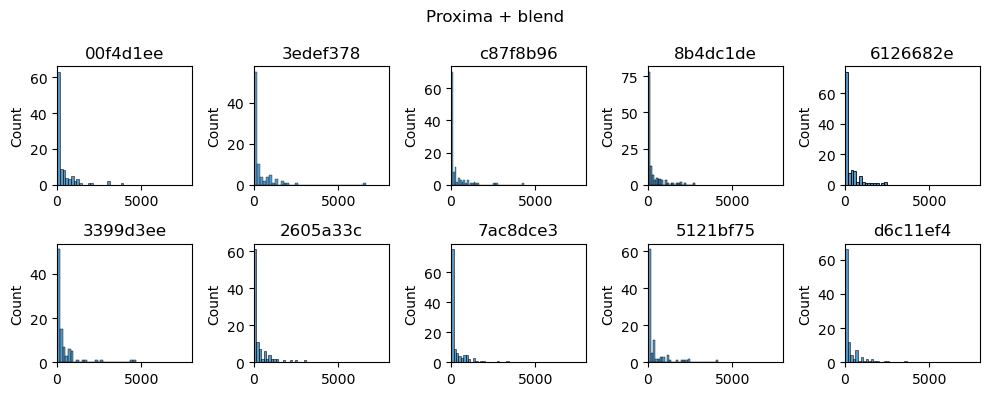

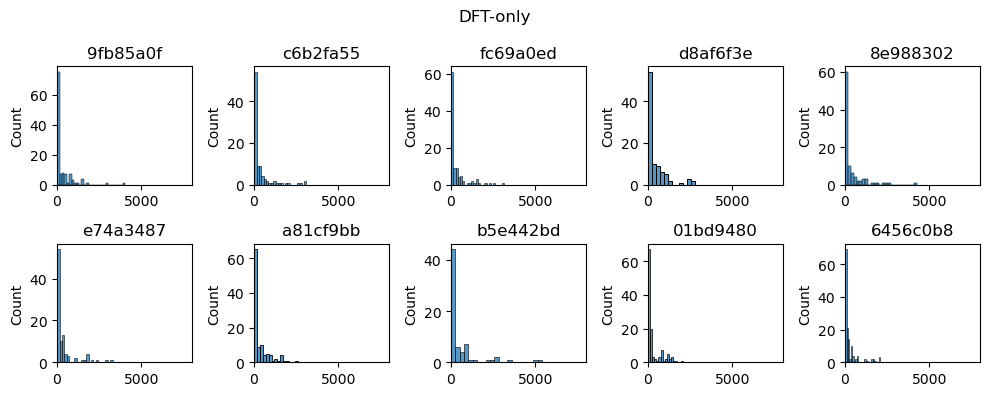

In [13]:
for (frac, n_blend), g in df.groupby(['min_target_frac', 'n_blending_steps']): 
    fig, axs = plt.subplots(2, 5, figsize=(10,4))
    for i, (_, row) in enumerate(g.iterrows()):
        ax = axs.ravel()[i]
        sns.histplot(row['durations'], ax=ax)
        ax.set_title(row['hash'])
        ax.set_xlim(0, 8000)
    if frac == 1: 
        title = 'DFT-only'
    elif n_blend == 0: 
        title = 'Proxima'
    else:
        title = 'Proxima + blend'
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

Actually, lets just combine them  

In [14]:
new_df = []
for (frac, n_blend), g in df.groupby(['min_target_frac', 'n_blending_steps']): 
    durations = []
    for i, (_, row) in enumerate(g.iterrows()):
        durations.extend(row['durations'])
        
    if frac == 1: 
        title = 'DFT-only'
    elif n_blend == 0: 
        title = 'Proxima'
    else:
        title = 'Proxima + blend'
    new_df.append([title, durations])
new_df = pd.DataFrame(new_df, columns=['condition', 'duration'])

In [15]:
df_long = new_df.explode('duration')

In [16]:
df_long

,condition,duration
0,Proxima,34
0,Proxima,1053
0,Proxima,35
0,Proxima,365
0,Proxima,53
...,...,...
2,DFT-only,44
2,DFT-only,769
2,DFT-only,40
2,DFT-only,381


<Axes: xlabel='condition', ylabel='duration'>

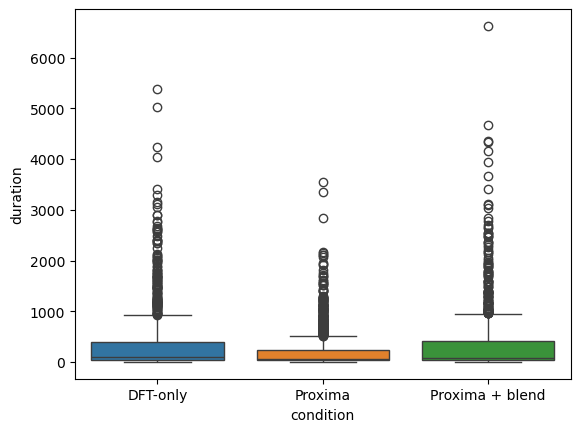

In [56]:
sns.boxplot(x='condition', 
            y='duration',
            hue='condition',
            data=df_long)
#plt.yscale('log')

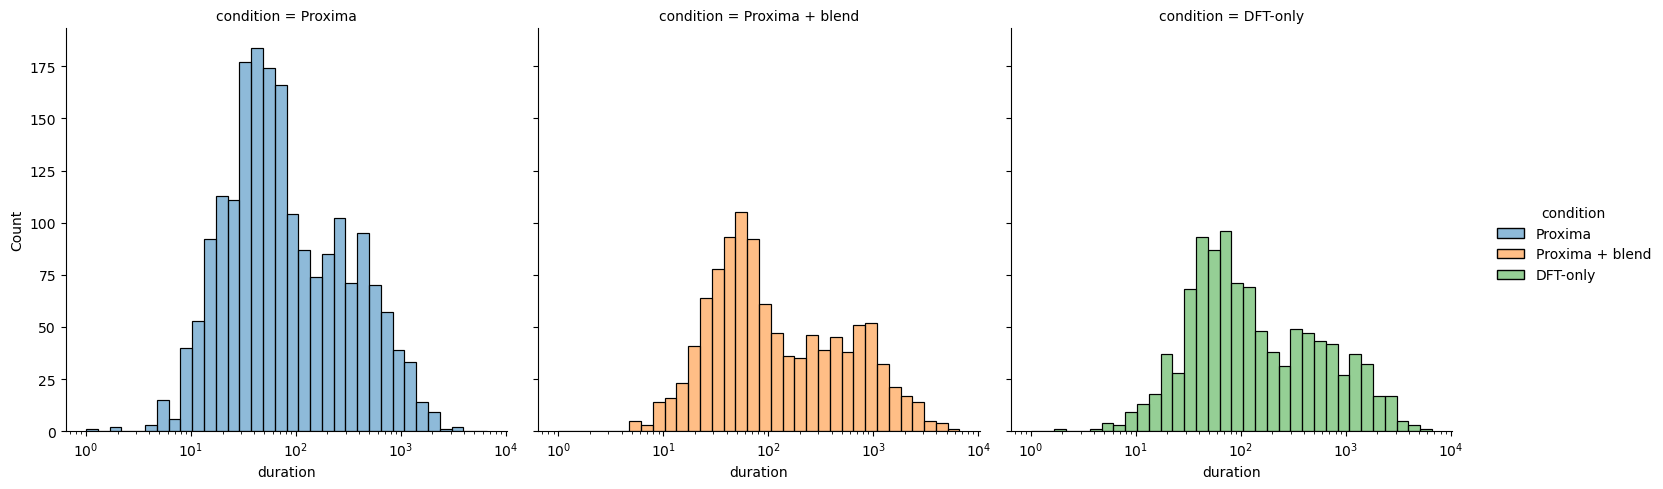

In [26]:
sns.displot(x='duration',
            col='condition',
            hue='condition',
            log_scale=(True, False),
            #rug=True,
            data=df_long)


In [19]:
means = df_long.groupby('condition').mean()#.reset_index()
means

,duration
condition,
DFT-only,372.740097
Proxima,197.685354
Proxima + blend,357.569573


In [36]:
1/means

,duration
condition,
DFT-only,0.002683
Proxima,0.005059
Proxima + blend,0.002797


In [20]:
means['duration']  / np.sqrt(df_long.groupby('condition').size())

condition
DFT-only           11.586064
Proxima             4.442648
Proxima + blend    10.890584
dtype: object

In [27]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [28]:
df_long

,condition,duration
0,Proxima,34
0,Proxima,1053
0,Proxima,35
0,Proxima,365
0,Proxima,53
...,...,...
2,DFT-only,44
2,DFT-only,769
2,DFT-only,40
2,DFT-only,381


In [32]:
df_long['duration'] = df_long['duration'].astype(int)

In [33]:
df_long['condition'] = pd.Categorical(df_long['condition'])

In [34]:
formula = 'duration ~ C(condition)'

In [35]:
mod1 = smf.glm(formula=formula, data=df_long, family=sm.families.Poisson()).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                 4093
Model:                            GLM   Df Residuals:                     4090
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0210e+06
Date:                Mon, 04 Nov 2024   Deviance:                   2.0155e+06
Time:                        11:20:44   Pearson chi2:                 3.30e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [47]:
?sns.displot

Signature:
sns.displot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    row=None,
    col=None,
    weights=None,
    kind='hist',
    rug=False,
    rug_kws=None,
    log_scale=None,
    legend=True,
    palette=None,
    hue_order=None,
    hue_norm=None,
    color=None,
    col_wrap=None,
    row_order=None,
    col_order=None,
    height=5,
    aspect=1,
    facet_kws=None,
    **kwargs,
)
Docstring:
Figure-level interface for drawing distribution plots onto a FacetGrid.

This function provides access to several approaches for visualizing the
univariate or bivariate distribution of data, including subsets of data
defined by semantic mapping and faceting across multiple subplots. The
``kind`` parameter selects the approach to use:

- :func:`histplot` (with ``kind="hist"``; the default)
- :func:`kdeplot` (with ``kind="kde"``)
- :func:`ecdfplot` (with ``kind="ecdf"``; univariate-only)

Additionally, a :func:`rugplot` can be added to any kind of plot to show
individual 

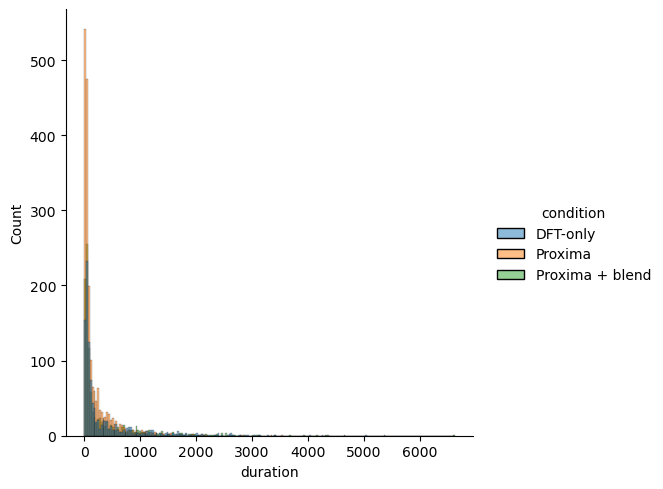

In [55]:
sns.displot(x='duration',
            #col='condition',
            hue='condition',
            #log_scale=(True, False),
            #rug=True,
            common_norm=False,
            #kind='kde',
            data=df_long)
